In [7]:
#Imports e setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Parâmetros
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Usando dispositivo:", DEVICE)


Usando dispositivo: cuda


In [ ]:
from torch.utils.data import ConcatDataset

# Caminhos dos datasets
cwru_root = "../images/cwru"
hust_root = "../images/hust"

# Transformações
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Carregar datasets individuais
cwru_dataset = datasets.ImageFolder(root=cwru_root, transform=transform)
hust_dataset = datasets.ImageFolder(root=hust_root, transform=transform)

# Índices das classes "normal"
cwru_normal_idx = cwru_dataset.class_to_idx['normal']
hust_normal_idx = hust_dataset.class_to_idx['normal']

# Filtrar apenas imagens normais de cada dataset
cwru_normal = Subset(cwru_dataset, [i for i, (_, lbl) in enumerate(cwru_dataset) if lbl == cwru_normal_idx])
hust_normal = Subset(hust_dataset, [i for i, (_, lbl) in enumerate(hust_dataset) if lbl == hust_normal_idx])

# Unir os datasets
combined_normal_dataset = ConcatDataset([cwru_normal, hust_normal])

# Dataloader
train_loader = DataLoader(combined_normal_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [4]:
#Definição do autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # nn.Conv2d(3, 8, 3, stride=2, padding=1),  # 
            # nn.ReLU(),
            # nn.Conv2d(8, 16, 3, stride=2, padding=1),  # 
            # nn.ReLU(),
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 56x56
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 28x28
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            # nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            # nn.Sigmoid(),
            # nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)


In [9]:
#Loop de treino
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


Epoch 1/20 - Loss: 0.0032
Epoch 2/20 - Loss: 0.0021
Epoch 3/20 - Loss: 0.0018
Epoch 4/20 - Loss: 0.0017
Epoch 5/20 - Loss: 0.0016
Epoch 6/20 - Loss: 0.0015
Epoch 7/20 - Loss: 0.0014
Epoch 8/20 - Loss: 0.0013
Epoch 9/20 - Loss: 0.0012
Epoch 10/20 - Loss: 0.0013
Epoch 11/20 - Loss: 0.0012
Epoch 12/20 - Loss: 0.0011
Epoch 13/20 - Loss: 0.0010
Epoch 14/20 - Loss: 0.0011
Epoch 15/20 - Loss: 0.0010
Epoch 16/20 - Loss: 0.0010
Epoch 17/20 - Loss: 0.0010
Epoch 18/20 - Loss: 0.0009
Epoch 19/20 - Loss: 0.0009
Epoch 20/20 - Loss: 0.0009


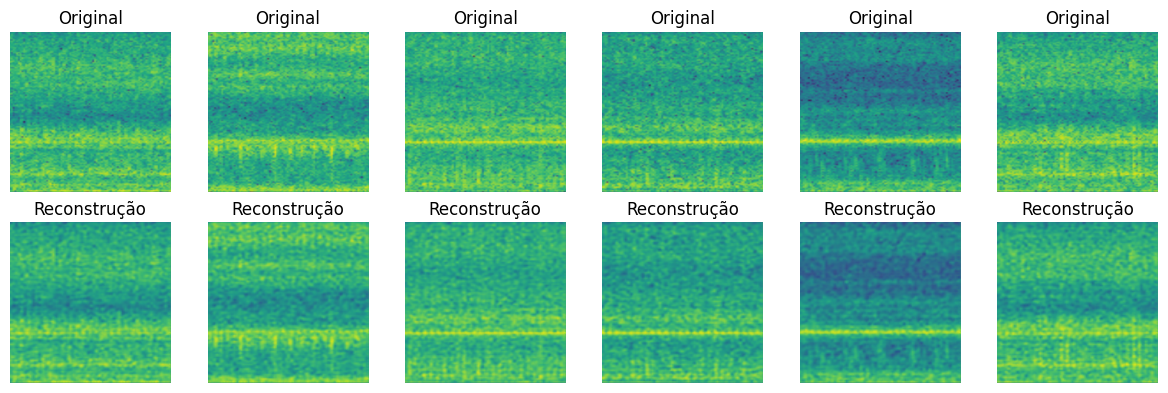

In [10]:
# Visualizações
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(train_loader))
    imgs = imgs.to(DEVICE)
    recon = model(imgs)

# Mostrar algumas imagens
n = 6
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(imgs[i].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title("Original")

    plt.subplot(2, n, i+1+n)
    plt.imshow(recon[i].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title("Reconstrução")
plt.tight_layout()
plt.show()
